Experiment 1B - Question/Task Independent Experiment
1) Same hyperparameters as Exeriment 1A
2) Keep certain tasks (totalling ~37k records) out from training and validation set
3) Test model on the tasks that were kept out to simulate using the model on new questions or new courses

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import tokenize
import io
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import lime
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import keras_tuner as kt
import json
import pickle
from tensorflow.keras.utils import plot_model

In [96]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, LSTM, SimpleRNN, SpatialDropout1D, Attention, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [97]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [98]:
df_code_py = pd.read_parquet('df_code_py.gzip')

In [99]:
df_code_py.head()

,academic_year_1,task,user,date,academic_year_0,upload,module,correct,hour_submitted,tokens,token_count,line_count,token_code_only,token_per_line
0,2017,add.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:11:41,2016,#!/usr/bin/env python\n\na = int(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, int, (, raw_input, (, ), ), \n, b, ...",7.5
1,2017,concat-lines.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:17:33,2016,#!/usr/bin/env python\n\na = str(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, str, (, raw_input, (, ), ), \n, b, ...",7.5
2,2017,goodbye.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 10:15:59,2016,"#!/usr/bin/env python\n\nprint ""Goodbye""\n",ca277,True,10,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",7,2,"[\n, print, ""Goodbye"", \n]",3.5
3,2017,less-than.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:14:22,2016,#!/usr/bin/env python\n\na = int(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, int, (, raw_input, (, ), ), \n, b, ...",7.5
4,2017,longest-line.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:51:28,2016,#!usr/bin/evn python\n\na = raw_input()\nb = r...,ca277,True,14,"[{'end': [1, 20], 'line': '#!usr/bin/evn pytho...",42,7,"[\n, a, =, raw_input, (, ), \n, b, =, raw_inpu...",6.0


In [100]:
df_code_py.shape

(378455, 14)

In [101]:
df_code_py_exp = df_code_py
#df_code_py_exp = df_code_py[df_code_py["task"]=="ex3-first-long-word.py"]

In [102]:
df_code_py_exp.iloc[0].tokens

array([{'end': array([ 1, 21], dtype=int64), 'line': '#!/usr/bin/env python\n', 'start': array([1, 0], dtype=int64), 'string': '#!/usr/bin/env python', 'type': 61},
       {'end': array([ 1, 22], dtype=int64), 'line': '#!/usr/bin/env python\n', 'start': array([ 1, 21], dtype=int64), 'string': '\n', 'type': 62},
       {'end': array([2, 1], dtype=int64), 'line': '\n', 'start': array([2, 0], dtype=int64), 'string': '\n', 'type': 62},
       {'end': array([3, 1], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 0], dtype=int64), 'string': 'a', 'type': 1},
       {'end': array([3, 3], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 2], dtype=int64), 'string': '=', 'type': 54},
       {'end': array([3, 7], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 4], dtype=int64), 'string': 'int', 'type': 1},
       {'end': array([3, 8], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 7], dtype=int64), 'string': '(', 'type': 5

In [103]:
MAX_NUM_WORDS = 100
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 50

In [104]:
def tokenizer_custom(t_list):    
    
    if isinstance(t_list, np.ndarray):
        #print(t_list)
        return t_list
    else:
        temp_tokens = None
        t_dict = None
        t_code_only = []
        with io.StringIO(t_list) as f:
            line = f.readline
            temp_tokens = tokenize.generate_tokens(line)
            try:
                for token in temp_tokens:
                    t_dict = token._asdict()
                    #print(t_dict)
                    #print(t_dict["string"])
                    if t_dict["line"] == "\n" or t_dict["type"] == 0:
                        pass
                    elif t_dict["type"] != 61:
                        # tokenize only the code not comments
                        t_code_only.append(t_dict["string"])
            except:
                pass
        return np.array(t_code_only)

In [105]:
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS, filters=None, lower=True, analyzer=tokenizer_custom)

In [106]:
tokenizer.fit_on_texts(df_code_py_exp["token_code_only"].values)
word_index = tokenizer.word_index

In [107]:
X_values = tokenizer.texts_to_sequences(df_code_py_exp["token_code_only"].values)
X_values = pad_sequences(X_values, maxlen=MAX_SEQUENCE_LENGTH)


In [108]:
Y_values = df_code_py_exp["correct"].astype(int).values

In [109]:
print(X_values[0], Y_values[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1 18  4 47  2 51  2  3  3  1 61  4 47  2 51  2  3  3  1 16
 18 17 61  1] 1


In [110]:
print(df_code_py_exp.iloc[0].token_code_only, df_code_py_exp.iloc[0].correct)

['\n' 'a' '=' 'int' '(' 'raw_input' '(' ')' ')' '\n' 'b' '=' 'int' '('
 'raw_input' '(' ')' ')' '\n' 'print' 'a' '+' 'b' '\n'] True


In [111]:
sum(df_code_py["task"].value_counts()[:21])

37992

In [112]:
df_code_py["task"].value_counts()[:21]

stableford_122.py           3115
ex3-strip-zeros.py          2602
ex2-third-words.py          2275
ex2-first-negative.py       1978
ex2-big-small-average.py    1978
small-primes.py             1918
wordcomps_031.py            1911
wordcomps_31.py             1856
selection_sort.py           1850
ex2-sum-arguments.py        1833
ex2-plurals.py              1812
ex2-absolute-values.py      1659
ex3-translation.py          1568
ex1-first-negative.py       1538
ex3_files.py                1484
ex2-first-plural.py         1481
sequence-7.py               1462
tempconv2.py                1452
ex2-countdown.py            1423
lcsub_122.py                1416
ex1-sum-five-positive.py    1381
Name: task, dtype: int64

In [113]:
test_list = list(df_code_py["task"].value_counts().index[:21])

In [114]:
X_train = X_values[~df_code_py["task"].isin(test_list)]

In [115]:
X_test = X_values[df_code_py["task"].isin(test_list)]

In [116]:
Y_train = Y_values[~df_code_py["task"].isin(test_list)]

In [117]:
Y_test = Y_values[df_code_py["task"].isin(test_list)]

In [118]:
I_train = df_code_py_exp.index[~df_code_py["task"].isin(test_list)]

In [119]:
I_test = df_code_py_exp.index[df_code_py["task"].isin(test_list)]

In [120]:
print("X_train: ", X_train.shape, "Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape, "Y_test: ", Y_test.shape)

X_train:  (340463, 100) Y_train:  (340463,)
X_test:  (37992, 100) Y_test:  (37992,)


In [121]:
print(X_train[0], Y_train[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1 18  4 47  2 51  2  3  3  1 61  4 47  2 51  2  3  3  1 16
 18 17 61  1] 1


In [122]:
print(df_code_py_exp.loc[I_train[0], "token_code_only"])

['\n' 'a' '=' 'int' '(' 'raw_input' '(' ')' ')' '\n' 'b' '=' 'int' '('
 'raw_input' '(' ')' ')' '\n' 'print' 'a' '+' 'b' '\n']


In [123]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [124]:
def model_builder(hp):    
    model_input = keras.Input(shape=(X_train.shape[1],))
    x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1])(model_input)
    hp_conv = hp.Int("units", min_value=3, max_value=7, step=1)
    hp_stride = hp.Int("stride", min_value=1, max_value=3, step=1)
    x = Conv1D(50, hp_conv, padding ="valid", activation ="relu", strides=hp_stride)(x)
    x = MaxPooling1D()(x)
    hp_do = hp.Choice("dropout", values = [0.05, 0.1, 0.15, 0.2])
    x = LSTM(50, activation="tanh", return_sequences=True, dropout=hp_do)(x)
    x = LSTM(25, activation="tanh", dropout=hp_do)(x)
    model_output = Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=model_input, outputs=model_output)
    hp_opt = hp.Choice("optimizer", values=["adam", "adafactor", "sgd"])
    model.compile(
    loss = "binary_crossentropy", 
    optimizer= hp_opt,
    metrics =["accuracy"],
    )
    return model

In [125]:
#plot_model(model, to_file="model_design.png", show_shapes=True, show_layer_names=True)

In [126]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     project_name="adaptive_lms")


INFO:tensorflow:Reloading Tuner from .\adaptive_lms\tuner0.json


In [127]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[callback])

INFO:tensorflow:Oracle triggered exit


In [128]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [129]:
best_hps.get("units")

3

In [130]:
best_hps.get("optimizer")

'adam'

In [131]:
best_hps.get("stride")

1

In [132]:
best_hps.get("dropout")

0.05

In [133]:
model = tuner.hypermodel.build(best_hps)

In [134]:
epochs = 100
batch_size = 128

In [135]:
history = model.fit(
    X_train, 
    Y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2,
    callbacks=[callback]
    )

Epoch 1/100
2128/2128 [==============================] - 47s 21ms/step - loss: 0.5775 - accuracy: 0.7106 - val_loss: 0.5333 - val_accuracy: 0.7561
Epoch 2/100
2128/2128 [==============================] - 42s 20ms/step - loss: 0.5376 - accuracy: 0.7335 - val_loss: 0.5274 - val_accuracy: 0.7577
Epoch 3/100
2128/2128 [==============================] - 44s 21ms/step - loss: 0.5139 - accuracy: 0.7479 - val_loss: 0.5136 - val_accuracy: 0.7538
Epoch 4/100
2128/2128 [==============================] - 44s 20ms/step - loss: 0.4942 - accuracy: 0.7579 - val_loss: 0.5104 - val_accuracy: 0.7553
Epoch 5/100
2128/2128 [==============================] - 42s 20ms/step - loss: 0.4789 - accuracy: 0.7675 - val_loss: 0.5125 - val_accuracy: 0.7544
Epoch 6/100
2128/2128 [==============================] - 41s 19ms/step - loss: 0.4664 - accuracy: 0.7738 - val_loss: 0.5076 - val_accuracy: 0.7589
Epoch 7/100
2128/2128 [==============================] - 41s 19ms/step - loss: 0.4541 - accuracy: 0.7814 - val_loss: 0

In [136]:
model.save("CNN-LSTM-New-Course.h5")

In [137]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [138]:
test_accuracy = model.evaluate(X_test, Y_test)

1188/1188 [==============================] - 9s 7ms/step - loss: 0.3642 - accuracy: 0.8595


In [139]:
Y_pred = model.predict(X_test)

1188/1188 [==============================] - 8s 6ms/step


In [140]:
Y_pred = np.round(Y_pred, 0)

In [174]:
metric_report = classification_report(Y_test, Y_pred, output_dict=True)

In [176]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     34456
           1       0.24      0.23      0.23      3536

    accuracy                           0.86     37992
   macro avg       0.58      0.58      0.58     37992
weighted avg       0.86      0.86      0.86     37992



In [200]:
tarcsay_cnn = {"precision":[0.52, 0.76], "recall":[0.55, 0.29], "f1-score":[0.62, 0.38], "accuracy":[0.53, 0.53]}
tarcsay_lstm = {"precision":[0.53, 0.56], "recall":[0.73, 0.35], "f1-score":[0.61, 0.43], "accuracy":[0.54, 0.54]}

<Figure size 640x480 with 0 Axes>

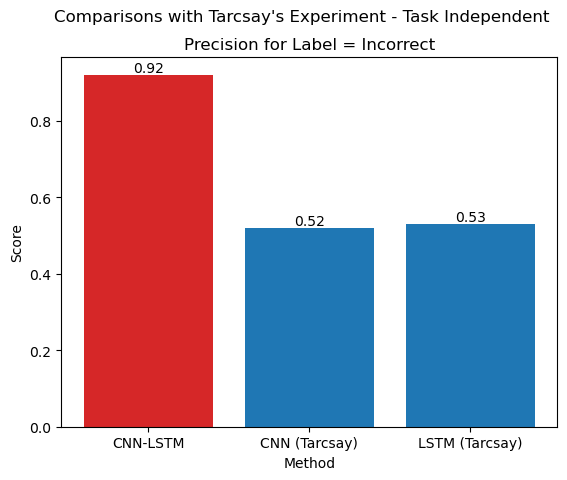

<Figure size 640x480 with 0 Axes>

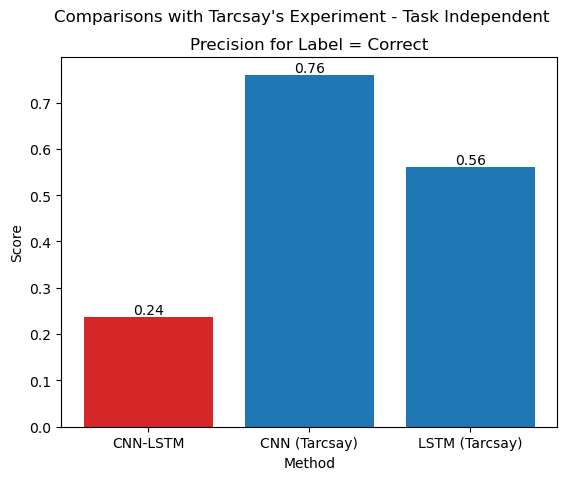

<Figure size 640x480 with 0 Axes>

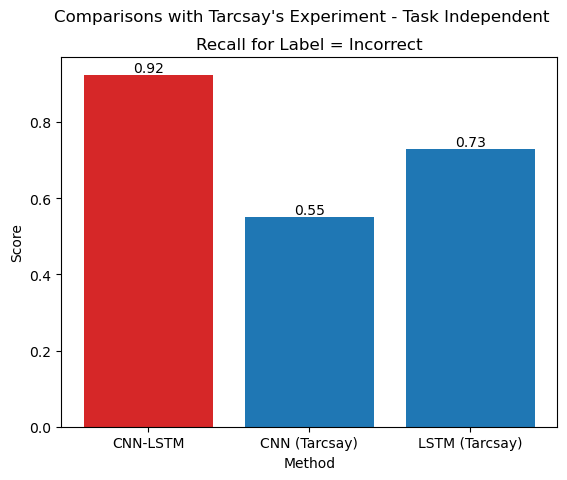

<Figure size 640x480 with 0 Axes>

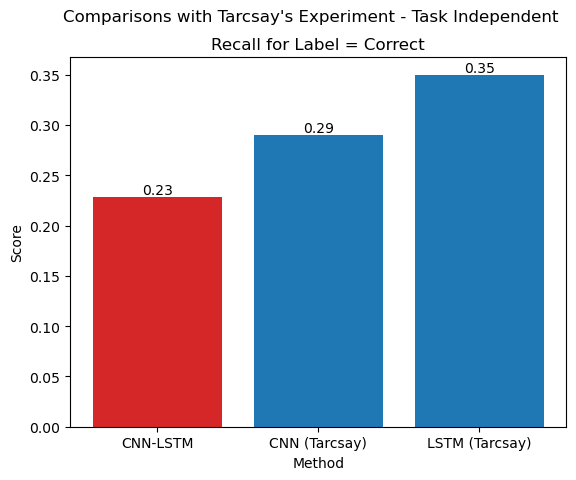

<Figure size 640x480 with 0 Axes>

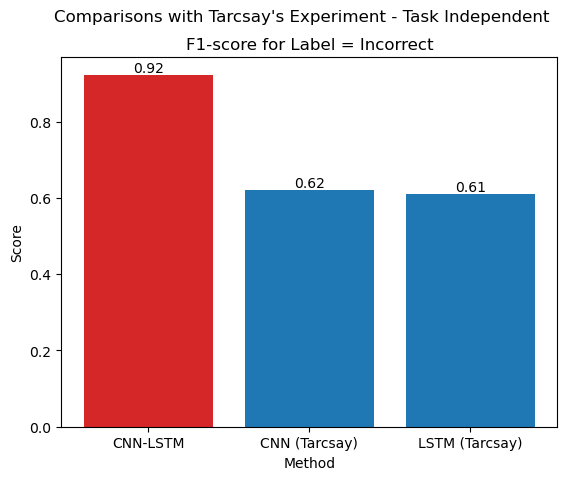

<Figure size 640x480 with 0 Axes>

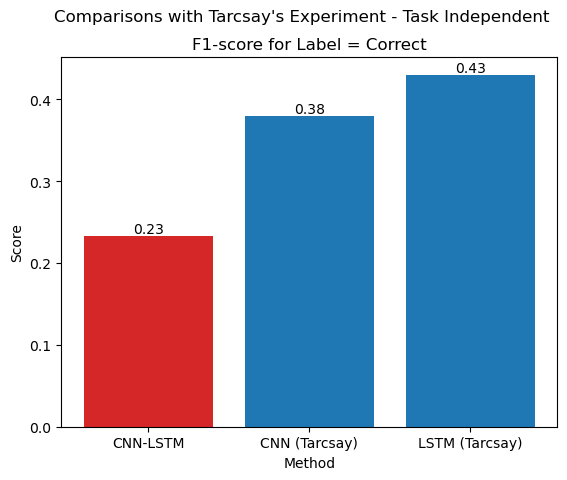

<Figure size 640x480 with 0 Axes>

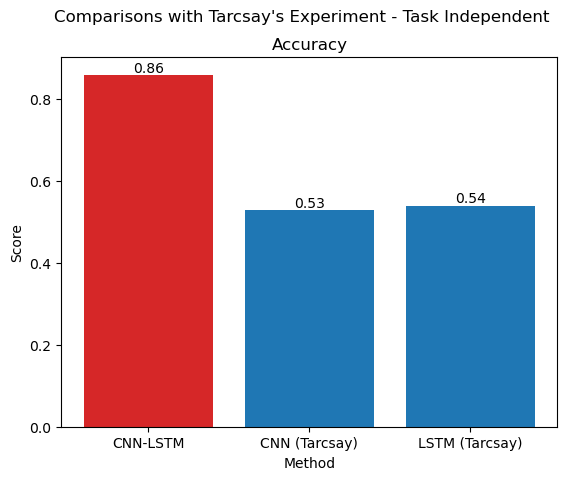

<Figure size 640x480 with 0 Axes>

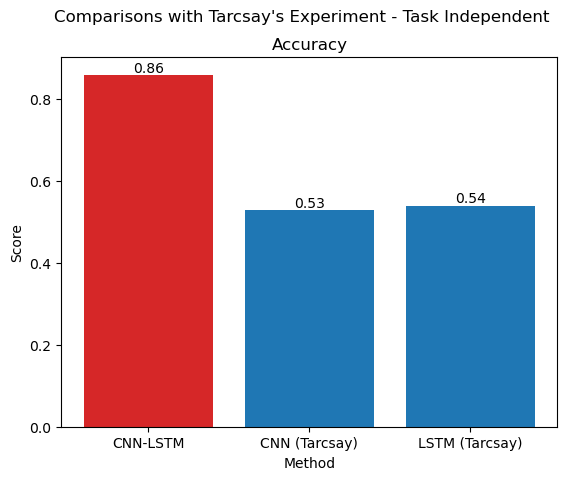

In [209]:
for metric in tarcsay_cnn.keys():
    for correct in [0, 1]:
        plt.figure()
        fig, ax = plt.subplots()
        classification = "Correct" if correct == 1 else "Incorrect"
        plt.title(str.capitalize(metric)+
                    ("" if metric == "accuracy" else " for Label = "+classification))
        plt.suptitle("Comparisons with Tarcsay's Experiment - Task Independent")
        plt.xlabel("Method")
        plt.ylabel("Score")
        y = [(metric_report[metric] if metric == "accuracy" else metric_report[str(correct)][metric]),
                tarcsay_cnn[metric][correct], tarcsay_lstm[metric][correct]]
        p = ax.bar(["CNN-LSTM", "CNN (Tarcsay)", "LSTM (Tarcsay)"], y, 
                   color=["tab:red", "tab:blue", "tab:blue"])
        ax.bar_label(p, labels= [round(i,2) for i in y], label_type = "edge")
        plt.show()

In [142]:
print(confusion_matrix(Y_test, Y_pred))

[[31845  2611]
 [ 2727   809]]


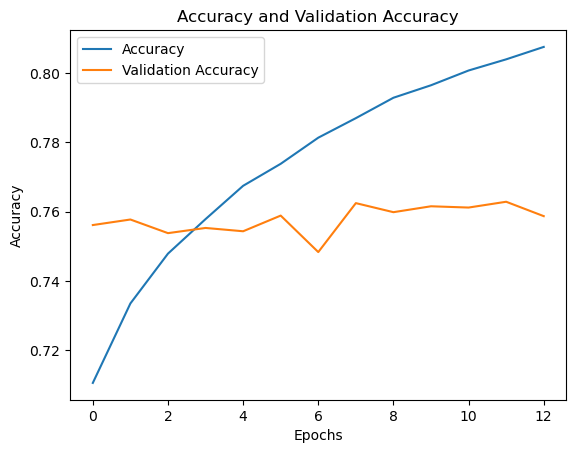

In [155]:
plt.title("Accuracy and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

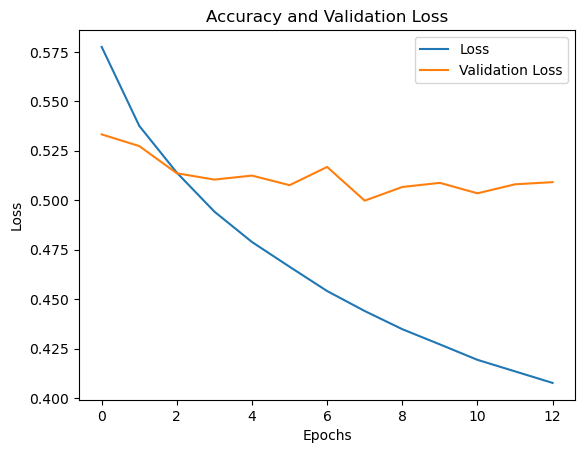

In [156]:
plt.title("Accuracy and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [145]:
#model = keras.Model(inputs=model.input, outputs=[model.output, model.get_layer('attention_vec').output])

In [146]:
test_case_raw = 'print "Hello World"'
#test_case_raw = 'if 2==3: print "true" else: print "false"' 

In [147]:
def predict_fn (code):
    predictions = []
    if isinstance(code, list) or isinstance(code, np.ndarray):
        m_input = code
    else:
        m_input = [code]
    
    for m in m_input:
        m_input = tokenizer.texts_to_sequences([m])
        m_input = pad_sequences(m_input, maxlen=MAX_SEQUENCE_LENGTH)
        prob = model.predict(m_input)
        predictions.append([1-prob[0][0], prob[0][0]])
    return np.array(predictions)



In [148]:
predict_fn(test_case_raw)

1/1 [==============================] - 0s 30ms/step


array([[0.13408715, 0.86591285]])

In [149]:
predict_fn(test_case_raw)[0,1]

1/1 [==============================] - 0s 27ms/step


0.8659128546714783

In [150]:
#int(pl.predict_proba([test_case_raw])[0,1])

In [151]:
#attention_outputs = outputs[1]

In [152]:
#print(attention_outputs)